## PyTorch Tutorial 14 - Convolutional Neural Network (CNN)
https://www.youtube.com/watch?v=pDdP0TFzsoQ

We do image recognition based on CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html

* 10 classess..

* available in pytorch directly

* The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


CNN mainly work image data and apply image filters

<img src="images/cnn-overview.png">

<img src="images/cnn-layer.png">

<img src="images/cnn-layer-calc.png">

<img src="images/cnn-kernel-matrix.png">

<img src="images/cnn-filter-work.png">

Max pooling helps reduce computational costs, by reducing size of image and hence number of parameters to learn in the model. It also helps void overfitting as it is more on abstracted form of input :

<img src="images/cnn-maxpooling.png">

<img src="images/cnn-architecture.png">

In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

In [252]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device:{device}")

device:cpu


In [253]:
#transforms.Normalize?

Files already downloaded and verified
Files already downloaded and verified
Sample shape:torch.Size([4, 3, 32, 32]), label's shapetorch.Size([4])


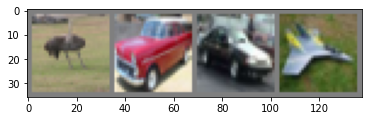

In [254]:
# hyper parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001
#
# dataset has PILImage images of range[0,1]
# We transform them to Tensors of normalized range [-1,1]
transform = transforms.Compose( [transforms.ToTensor(), 
                                 transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
#
train_dataset = torchvision.datasets.CIFAR10(root = "./data", 
                                           train = True,
                                           transform = transform,
                                           download = True)
#
test_dataset = torchvision.datasets.CIFAR10(root = "./data", 
                                            train     = False,
                                            transform = transform,
                                            download  = True)
#
# we shuffle
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = batch_size,
                                           shuffle = True)
#
# we dont shuffle
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                           batch_size = batch_size,
                                          shuffle = False)
#
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# To display  images 
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Put the 0-th dimension at the end
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# print shape
print(f"Sample shape:{samples.shape}, label's shape{labels.shape}")

# show images
imshow(torchvision.utils.make_grid(images))

torch.Size([4, 3, 32, 32]) torch.Size([4])

4 : batch size - ie 4 examples in a batch

3 : RBG channel

32 x 32 is image size

<img src="images/cnn-architecture.png">

In [255]:
# To look at how layers work

conv1 = nn.Conv2d(3, 6, 5)  
pool = nn.MaxPool2d(2, 2)   #2 by 2 , and then stride is 2
conv2 = nn.Conv2d(6, 16, 5)  #input size 6 must be equal to last output size 6 as in nn.Conv2d(3, 6, 5)
print(f"images.shape: {images.shape}")
x = conv1(images)
print(f"conv1: x.shape: {x.shape}, by calculation:{(32 - 5)/1 + 1 }") #((w - f + 2*p)/s) + 1
x = pool(x)
print(f"pool: x.shape: {x.shape}, by calculation:{(28 - 2)/2 + 1 }") #((w - f + 2*p)/s) + 1 , filter size:2 and stride: 2
x = conv2(x)
print(f"Conv2: x.shape: {x.shape}, by calculation:{(14 - 5)/1 + 1 }") #((w - f + 2*p)/s) + 1 , filter size:5 and stride: 1
x = pool(x)
print(f"pool: x.shape: {x.shape}, by calculation:{(10 - 2)/2 + 1 }") #((w - f + 2*p)/s) + 1 , filter size:2 and stride: 2


images.shape: torch.Size([4, 3, 32, 32])
conv1: x.shape: torch.Size([4, 6, 28, 28]), by calculation:28.0
pool: x.shape: torch.Size([4, 6, 14, 14]), by calculation:14.0
Conv2: x.shape: torch.Size([4, 16, 10, 10]), by calculation:10.0
pool: x.shape: torch.Size([4, 16, 5, 5]), by calculation:5.0


That is why we will take Linear layer after flattening this to be 16x5x5

In [256]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device:{device}")



# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        #because 3 colour channels,
        #output channel size is 6 ?
        #5 is kernel size (it is always square , 5x5 in this case)
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)   #2 by 2 , and then stride is 2
        self.conv2 = nn.Conv2d(6, 16, 5)  #input size 6 must be equal to last output size 6 as in nn.Conv2d(3, 6, 5)
        # 16*5*5: derived above, 
        # second argument(120) is next hidden neural net layer size you can chose 100, 120 ...or anything
        self.fc1 = nn.Linear(16*5*5, 120) 
        self.fc2 = nn.Linear(120, 84) # 120 input, 84 output
        self.fc3 = nn.Linear(84, 10)  # 10 classes
        
    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

model = ConvNet()
    
criterion = nn.CrossEntropyLoss() #softmax embedded in crosentrupyloss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape [4,3,32,32]
        # we need 100, 784   (784 = 28 x 28)
        images = images.to(device)
        lables = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backwards 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

device:cpu
Epoch [1/5], Step [2000/12500], Loss: 2.2746
Epoch [1/5], Step [4000/12500], Loss: 2.3351
Epoch [1/5], Step [6000/12500], Loss: 2.2917
Epoch [1/5], Step [8000/12500], Loss: 2.3091
Epoch [1/5], Step [10000/12500], Loss: 2.2897
Epoch [1/5], Step [12000/12500], Loss: 2.2386
Epoch [2/5], Step [2000/12500], Loss: 2.1135
Epoch [2/5], Step [4000/12500], Loss: 1.8270
Epoch [2/5], Step [6000/12500], Loss: 1.6925
Epoch [2/5], Step [8000/12500], Loss: 1.8088
Epoch [2/5], Step [10000/12500], Loss: 1.7807
Epoch [2/5], Step [12000/12500], Loss: 2.2355
Epoch [3/5], Step [2000/12500], Loss: 1.6200
Epoch [3/5], Step [4000/12500], Loss: 1.5472
Epoch [3/5], Step [6000/12500], Loss: 1.4560
Epoch [3/5], Step [8000/12500], Loss: 1.4785
Epoch [3/5], Step [10000/12500], Loss: 1.7110
Epoch [3/5], Step [12000/12500], Loss: 1.7139
Epoch [4/5], Step [2000/12500], Loss: 1.4759
Epoch [4/5], Step [4000/12500], Loss: 1.8860
Epoch [4/5], Step [6000/12500], Loss: 1.4315
Epoch [4/5], Step [8000/12500], Loss: 

In [257]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Finished Training
Accuracy of the network: 48.66 %
Accuracy of plane: 57.2 %
Accuracy of car: 54.9 %
Accuracy of bird: 30.5 %
Accuracy of cat: 36.7 %
Accuracy of deer: 30.9 %
Accuracy of dog: 42.6 %
Accuracy of frog: 55.2 %
Accuracy of horse: 61.8 %
Accuracy of ship: 60.1 %
Accuracy of truck: 56.7 %


Accuracy is not very good - we can increase number of ecpochs and retry. This was just for demo pusposes.
